In [154]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [155]:
# ⚙️ Configuration
SEED = 42
BATCH_SIZE = 32
NUM_CLASSES = 7
IMG_SIZE = 224
EPOCHS = 50
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seeds
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [156]:
# 🗂️ Custom Dataset Class
class LungHistDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [157]:

# 🧹 Data Preparation
image_paths = glob('/kaggle/input/lunghist/data/images/*/*.jpg')
labels = [os.path.basename(os.path.dirname(p)) for p in image_paths]
class_to_idx = {cls: idx for idx, cls in enumerate(sorted(set(labels)))}
idx_to_class = {v: k for k, v in class_to_idx.items()}
labels_idx = [class_to_idx[lbl] for lbl in labels]

# Stratified train/test split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels_idx, test_size=0.2, stratify=labels_idx, random_state=SEED
)


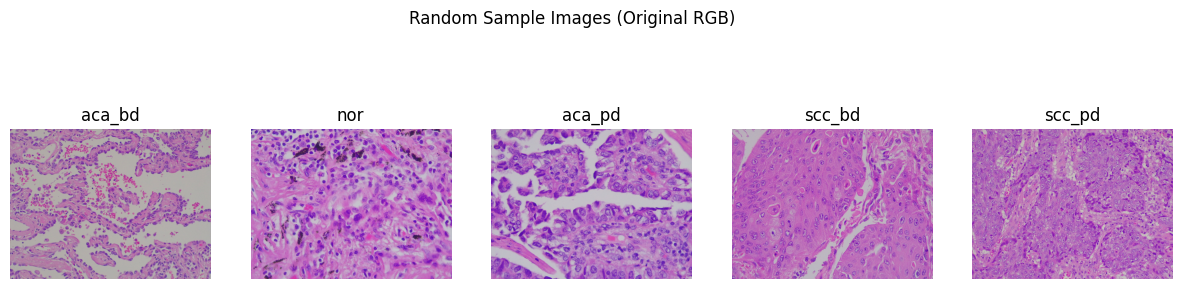

In [179]:
DATASET_DIR='/kaggle/input/lunghist/data/images'
classes = sorted(os.listdir(DATASET_DIR))
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for ax in axes:
    cls_name = random.choice(classes)
    img_file = random.choice(os.listdir(os.path.join(DATASET_DIR, cls_name)))
    img_path = os.path.join(DATASET_DIR, cls_name, img_file)
    image = Image.open(img_path).convert("RGB")  # Keep original RGB
    ax.imshow(image)
    ax.set_title(cls_name)
    ax.axis('off')
plt.suptitle("Random Sample Images (Original RGB)")
plt.show()

In [181]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE + 32, IMG_SIZE + 32)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

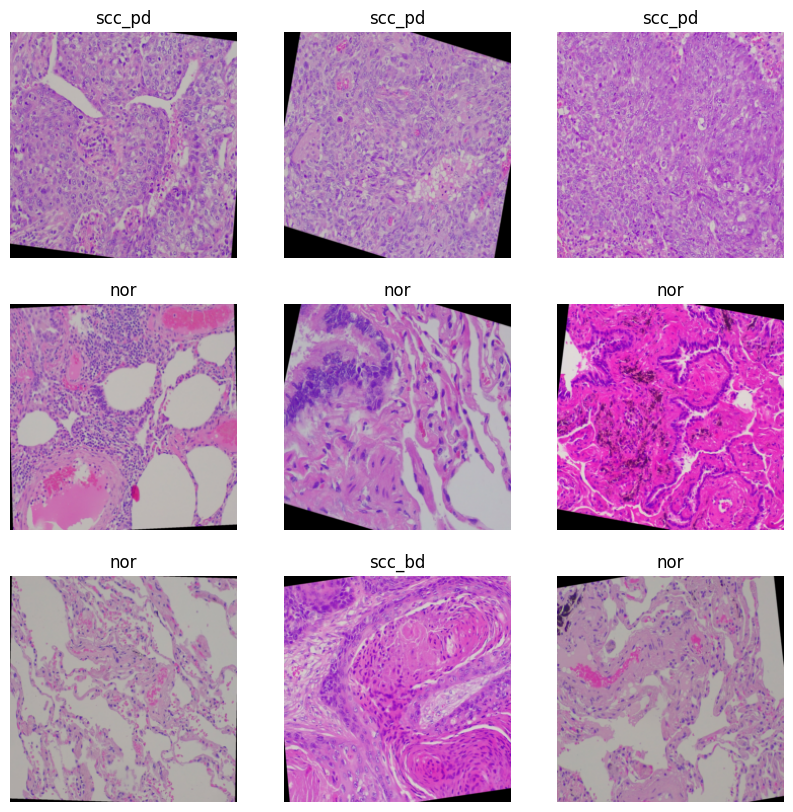

In [186]:
# 📦 Datasets & Dataloaders
train_dataset = LungHistDataset(train_paths, train_labels, transform=train_transform)
test_dataset = LungHistDataset(test_paths, test_labels, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 👀 Visualize 8 Samples
def show_samples(dataset):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        img, lbl = dataset[random.randint(0, len(dataset)-1)]
        plt.subplot(3, 3, i+1)
        img = img.permute(1, 2, 0) * 0.5 + 0.5
      
        plt.imshow(img)
        plt.title(idx_to_class[lbl])
        plt.axis('off')
    plt.show()

show_samples(train_dataset)

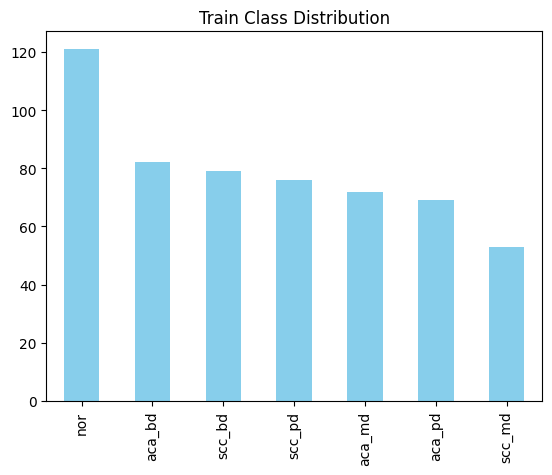

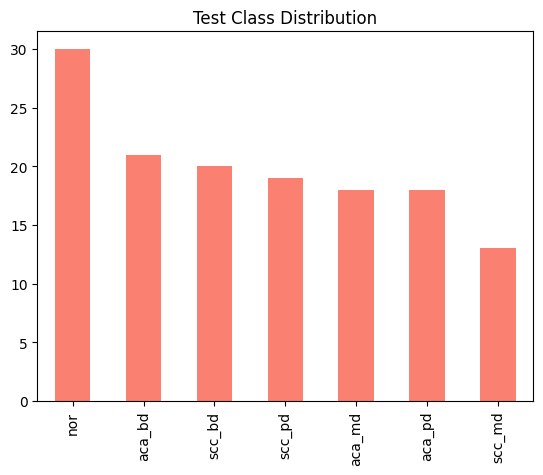

In [169]:
# 📊 Class Distribution
import pandas as pd
train_dist = pd.Series(train_labels).map(idx_to_class).value_counts()
test_dist = pd.Series(test_labels).map(idx_to_class).value_counts()
train_dist.plot(kind='bar', title='Train Class Distribution', color='skyblue')
plt.show()
test_dist.plot(kind='bar', title='Test Class Distribution', color='salmon')
plt.show()

# 🧠 CBAM Block (Optional)
class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
        self.spatial = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        avg = self.fc(self.avg_pool(x).view(b, c))
        max = self.fc(self.max_pool(x).view(b, c))
        att = self.sigmoid(avg + max).view(b, c, 1, 1)
        x = x * att
        avg = torch.mean(x, dim=1, keepdim=True)
        max = torch.max(x, dim=1, keepdim=True)[0]
        x = torch.cat([avg, max], dim=1)
        x = self.spatial(x)
        return x

In [161]:
# 🔗 Hybrid Model
class HybridNet(nn.Module):
    def __init__(self):
        super(HybridNet, self).__init__()
        self.effnet = models.efficientnet_b0(pretrained=True)
        self.resnet = models.resnet18(pretrained=True)
        self.densenet = models.densenet121(pretrained=True)

        for param in self.effnet.parameters(): param.requires_grad = False
        for param in self.resnet.parameters(): param.requires_grad = False
        for param in self.densenet.parameters(): param.requires_grad = False

        self.effnet_out = self.effnet.classifier[1].in_features
        self.resnet_out = self.resnet.fc.in_features
        self.densenet_out = self.densenet.classifier.in_features

        self.cbam = CBAM(self.effnet_out + self.resnet_out + self.densenet_out)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.effnet_out + self.resnet_out + self.densenet_out, 256),
            nn.ReLU(),
            nn.Linear(256, NUM_CLASSES)
        )

    def forward(self, x):
        x1 = self.effnet.features(x).mean([2, 3])
        x2 = self.resnet.conv1(x)
        x2 = self.resnet.bn1(x2)
        x2 = self.resnet.relu(x2)
        x2 = self.resnet.maxpool(x2)
        x2 = self.resnet.layer1(x2)
        x2 = self.resnet.layer2(x2)
        x2 = self.resnet.layer3(x2)
        x2 = self.resnet.layer4(x2)
        x2 = F.adaptive_avg_pool2d(x2, (1, 1)).view(x2.size(0), -1)
        x3 = self.densenet.features(x)
        x3 = F.relu(x3, inplace=True)
        x3 = F.adaptive_avg_pool2d(x3, (1, 1)).view(x3.size(0), -1)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return self.classifier(x_cat)


# import timm
# import torch.nn as nn
# import torchvision.models as models

# class HybridNet(nn.Module):
#     def __init__(self, num_classes=7):
#         super(HybridNet, self).__init__()

#         # EfficientNetB3
#         self.eff = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0, global_pool='')
#         self.eff_out = self.eff.num_features

#         # ResNet50
#         resnet = models.resnet50(pretrained=True)
#         self.res = nn.Sequential(*list(resnet.children())[:-2])  # Remove avgpool & fc
#         self.res_out = 2048

#         # Swin Transformer Tiny
#         self.swin = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=0, global_pool='')
#         self.swin_out = self.swin.num_features

#         self.pool = nn.AdaptiveAvgPool2d(1)

    #     # Combined head
    #     total_features = self.eff_out + self.res_out + self.swin_out
    #     self.classifier = nn.Sequential(
    #         nn.Dropout(0.5),
    #         nn.Linear(total_features, 256),
    #         nn.ReLU(),
    #         nn.Linear(256, num_classes)
    #     )

    # def forward(self, x):
    #     eff_feat = self.pool(self.eff(x)).squeeze(-1).squeeze(-1)
    #     res_feat = self.pool(self.res(x)).squeeze(-1).squeeze(-1)
    #     swin_feat = self.pool(self.swin(x)).squeeze(-1).squeeze(-1)

    #     features = torch.cat((eff_feat, res_feat, swin_feat), dim=1)
    #     out = self.classifier(features)
    #     return out


In [162]:
# 🚂 Training & Evaluation Functions
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct = 0, 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (outputs.argmax(1) == y).sum().item()
    return running_loss / len(loader), correct / len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct = 0, 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            outputs = model(x)
            loss = criterion(outputs, y)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == y).sum().item()
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_targets.extend(y.cpu().numpy())
    return running_loss / len(loader), correct / len(loader.dataset), all_preds, all_targets


In [163]:
# 🏃 Train the Model
model = HybridNet().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = evaluate(model, test_loader, criterion)
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{EPOCHS} => Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most u

Epoch 1/50 => Train Acc: 0.3533, Val Acc: 0.4460
Epoch 2/50 => Train Acc: 0.5562, Val Acc: 0.5755
Epoch 3/50 => Train Acc: 0.6250, Val Acc: 0.7050
Epoch 4/50 => Train Acc: 0.5924, Val Acc: 0.6475
Epoch 5/50 => Train Acc: 0.6920, Val Acc: 0.6835
Epoch 6/50 => Train Acc: 0.7210, Val Acc: 0.7266
Epoch 7/50 => Train Acc: 0.7065, Val Acc: 0.7266
Epoch 8/50 => Train Acc: 0.7301, Val Acc: 0.7554
Epoch 9/50 => Train Acc: 0.7192, Val Acc: 0.7266
Epoch 10/50 => Train Acc: 0.7645, Val Acc: 0.7482
Epoch 11/50 => Train Acc: 0.7482, Val Acc: 0.7482
Epoch 12/50 => Train Acc: 0.7772, Val Acc: 0.7554
Epoch 13/50 => Train Acc: 0.7627, Val Acc: 0.7698
Epoch 14/50 => Train Acc: 0.7264, Val Acc: 0.7410
Epoch 15/50 => Train Acc: 0.7464, Val Acc: 0.6619
Epoch 16/50 => Train Acc: 0.7409, Val Acc: 0.7194
Epoch 17/50 => Train Acc: 0.7337, Val Acc: 0.7554
Epoch 18/50 => Train Acc: 0.7500, Val Acc: 0.7554
Epoch 19/50 => Train Acc: 0.7446, Val Acc: 0.7842
Epoch 20/50 => Train Acc: 0.7554, Val Acc: 0.7482
Epoch 21/

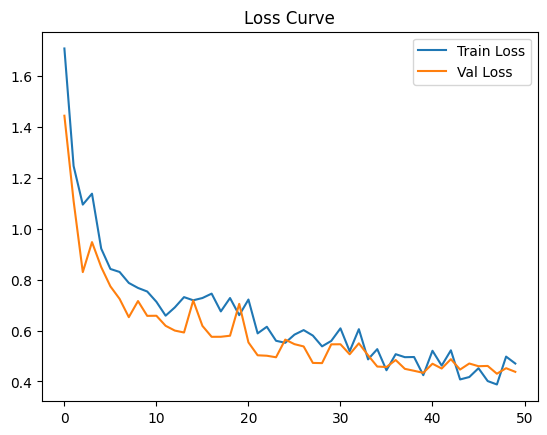

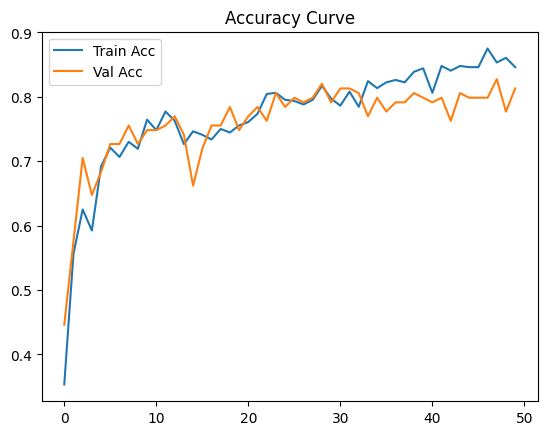

In [164]:
# 📈 Loss & Accuracy Curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title("Accuracy Curve")
plt.show()


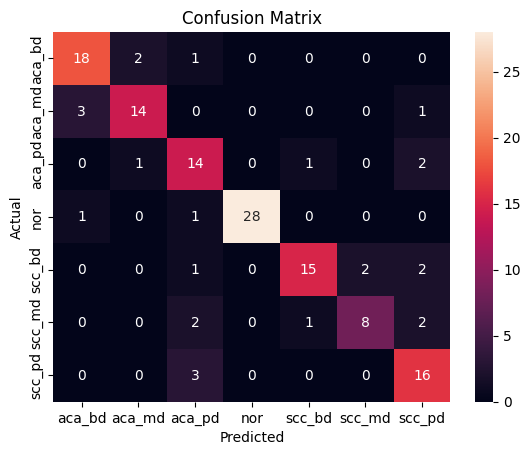

In [165]:

# 📉 Confusion Matrix & Report
_, _, preds, targets = evaluate(model, test_loader, criterion)
cm = confusion_matrix(targets, preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=idx_to_class.values(), yticklabels=idx_to_class.values())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [166]:

# 📋 Classification Report
print(classification_report(targets, preds, target_names=idx_to_class.values()))

              precision    recall  f1-score   support

      aca_bd       0.82      0.86      0.84        21
      aca_md       0.82      0.78      0.80        18
      aca_pd       0.64      0.78      0.70        18
         nor       1.00      0.93      0.97        30
      scc_bd       0.88      0.75      0.81        20
      scc_md       0.80      0.62      0.70        13
      scc_pd       0.70      0.84      0.76        19

    accuracy                           0.81       139
   macro avg       0.81      0.79      0.80       139
weighted avg       0.83      0.81      0.81       139



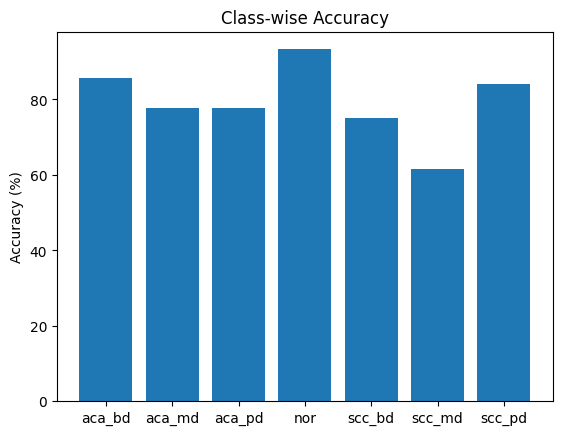

In [167]:
# 🔍 Class-wise Accuracy
class_correct = [0] * NUM_CLASSES
class_total = [0] * NUM_CLASSES
for i in range(len(targets)):
    label = targets[i]
    pred = preds[i]
    if label == pred:
        class_correct[label] += 1
    class_total[label] += 1

acc_per_class = [100 * c / t for c, t in zip(class_correct, class_total)]
plt.bar(idx_to_class.values(), acc_per_class)
plt.ylabel('Accuracy (%)')
plt.title('Class-wise Accuracy')
plt.show()

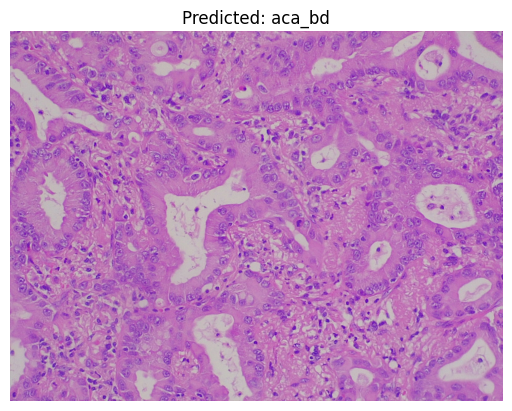

In [168]:
def predict_image(path):
    model.eval()
    img = Image.open(path).convert("RGB")
    trans = test_transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        output = model(trans)
        pred = output.argmax(1).item()
    plt.imshow(img)
    plt.title(f"Predicted: {idx_to_class[pred]}")
    plt.axis('off')
    plt.show()

predict_image('/kaggle/input/lunghist/data/images/aca_bd/aca_bd_20x_14.jpg')
